# Train the decision trees based on the latest data available from: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u

NB - there is no longer regular updating of case and death data. Must omit from model training. 

In [63]:
#%reset

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from num2words import num2words
import word2number
from word2number import w2n
import pickle
import pydotplus

import random
from matplotlib.patches import Polygon
import graphviz
import sklearn.tree as tree
from six import StringIO
from IPython.display import Image
import string
from PIL import Image
from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, pivot_data_by_HSA, merge_and_rename_data, add_changes_by_week, create_column_names, create_collated_weekly_data, simplify_labels_graphviz
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

In [88]:
directory_path = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Latest_data/"
os.chdir(directory_path)

# Import and prepare data

In [65]:
HSA_weekly_data_updated = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips_latest_data.csv")


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_56084/2636473005.py:1: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  HSA_weekly_data_updated = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips_latest_data.csv")


In [66]:
HSA_weekly_data_updated.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)
HSA_weekly_data_updated['beds_over_15_100k'] = (HSA_weekly_data_updated['beds_weekly'] > 15)*1
HSA_weekly_data_updated_features = HSA_weekly_data_updated.dropna(subset=['admits_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
for i, week in enumerate(HSA_weekly_data_updated_features['date'].unique()):
    HSA_weekly_data_updated_features.loc[HSA_weekly_data_updated_features['date'] == week, 'week'] = i

Merge dataframes

In [67]:
## pivot 
data_by_HSA_admissions = pivot_data_by_HSA(HSA_weekly_data_updated_features, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(HSA_weekly_data_updated_features, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(HSA_weekly_data_updated_features, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(HSA_weekly_data_updated_features, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_15_100k = pivot_data_by_HSA(HSA_weekly_data_updated_features, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_beds_perc_admits_icu = pd.merge(data_by_HSA_beds_perc_weekly, data_by_HSA_admits_icu_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_admits_icu_beds = pd.merge(data_by_HSA_cases_beds_perc_admits_icu, data_by_HSA_over_15_100k, on='week')

data_by_HSA_cases_admits_icu_beds = data_by_HSA_cases_admits_icu_beds.reset_index()
data_by_HSA_cases_admits_icu_beds.columns = data_by_HSA_cases_admits_icu_beds.columns.str.replace(',', '')

Get weekly changes

In [68]:
all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_admits_icu_beds, "beds_over_15_100k")

/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:348: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:348: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:348: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [69]:
categories_for_subsetting = [ 'admits', 'icu', 'beds', 'perc_covid',  'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_15_100k']
num_of_weeks = len(all_HSA_ID_weekly_data)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

In [70]:
all_HSA_ID_weekly_data = create_collated_weekly_data(all_HSA_ID_weekly_data, HSA_weekly_data_updated, categories_for_subsetting, 'HSA_ID', column_names)

Add weights 

In [71]:
weights_df = HSA_weekly_data_updated[HSA_weekly_data_updated['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

In [72]:
all_HSA_ID_weekly_data

,HSA_ID,week_one_admits,week_one_icu,week_one_beds,week_one_perc_covid,week_one_admits_delta,week_one_icu_delta,week_one_beds_delta,week_one_perc_covid_delta,week_one_beds_over_15_100k,...,week_one hundred and eighty_admits,week_one hundred and eighty_icu,week_one hundred and eighty_beds,week_one hundred and eighty_perc_covid,week_one hundred and eighty_admits_delta,week_one hundred and eighty_icu_delta,week_one hundred and eighty_beds_delta,week_one hundred and eighty_perc_covid_delta,week_one hundred and eighty_beds_over_15_100k,weight
0,1.0,2.637792,1.083379,17.805094,0.015306,NaN,NaN,NaN,NaN,1.0,...,13.848406,1.036275,77.155405,0.064935,-0.329724,0.282621,5.275583,0.004721,1.0,0.000021
1,2.0,6.324954,5.147092,66.186121,0.047243,NaN,NaN,NaN,NaN,1.0,...,10.390995,1.419888,55.795126,0.053488,0.225891,0.548593,-12.198125,-0.012799,1.0,0.000021
2,3.0,3.520466,1.700361,33.863527,0.030204,NaN,NaN,NaN,NaN,1.0,...,13.830401,1.185463,91.364465,0.063093,-4.274851,-0.610693,-11.399603,-0.007872,1.0,0.000021
3,4.0,4.572028,0.147882,8.626468,0.005084,NaN,NaN,NaN,NaN,0.0,...,12.077055,0.653147,47.531838,0.02751,0.905779,-0.147882,-7.505027,-0.004339,1.0,0.000021
4,5.0,2.81984,1.71876,50.00517,0.035691,NaN,NaN,NaN,NaN,1.0,...,7.143596,0.698246,30.078298,0.024272,1.691904,0.416262,4.887723,0.003923,1.0,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,823.0,2.481229,0.035446,2.481229,0.002847,NaN,NaN,NaN,NaN,0.0,...,3.473721,0.035446,15.383623,0.011841,-1.488738,0.0,-18.857344,-0.014515,1.0,0.000016
801,903.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000006
802,904.0,2.395345,1.366532,45.339347,0.025134,NaN,NaN,NaN,NaN,1.0,...,6.231029,0.25273,17.471931,0.010976,0.955007,0.084989,7.17038,0.004252,1.0,0.000006
803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000012


Save file

In [99]:
# write a csv file with all the data
all_HSA_ID_weekly_data.to_csv("/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Latest_data/hsa_time_data_all_dates_weekly_latest_data.csv", index=False)

In [74]:
all_HSA_ID_weekly_data

,HSA_ID,week_one_admits,week_one_icu,week_one_beds,week_one_perc_covid,week_one_admits_delta,week_one_icu_delta,week_one_beds_delta,week_one_perc_covid_delta,week_one_beds_over_15_100k,...,week_one hundred and eighty_admits,week_one hundred and eighty_icu,week_one hundred and eighty_beds,week_one hundred and eighty_perc_covid,week_one hundred and eighty_admits_delta,week_one hundred and eighty_icu_delta,week_one hundred and eighty_beds_delta,week_one hundred and eighty_perc_covid_delta,week_one hundred and eighty_beds_over_15_100k,weight
0,1.0,2.637792,1.083379,17.805094,0.015306,NaN,NaN,NaN,NaN,1.0,...,13.848406,1.036275,77.155405,0.064935,-0.329724,0.282621,5.275583,0.004721,1.0,0.000021
1,2.0,6.324954,5.147092,66.186121,0.047243,NaN,NaN,NaN,NaN,1.0,...,10.390995,1.419888,55.795126,0.053488,0.225891,0.548593,-12.198125,-0.012799,1.0,0.000021
2,3.0,3.520466,1.700361,33.863527,0.030204,NaN,NaN,NaN,NaN,1.0,...,13.830401,1.185463,91.364465,0.063093,-4.274851,-0.610693,-11.399603,-0.007872,1.0,0.000021
3,4.0,4.572028,0.147882,8.626468,0.005084,NaN,NaN,NaN,NaN,0.0,...,12.077055,0.653147,47.531838,0.02751,0.905779,-0.147882,-7.505027,-0.004339,1.0,0.000021
4,5.0,2.81984,1.71876,50.00517,0.035691,NaN,NaN,NaN,NaN,1.0,...,7.143596,0.698246,30.078298,0.024272,1.691904,0.416262,4.887723,0.003923,1.0,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,823.0,2.481229,0.035446,2.481229,0.002847,NaN,NaN,NaN,NaN,0.0,...,3.473721,0.035446,15.383623,0.011841,-1.488738,0.0,-18.857344,-0.014515,1.0,0.000016
801,903.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000006
802,904.0,2.395345,1.366532,45.339347,0.025134,NaN,NaN,NaN,NaN,1.0,...,6.231029,0.25273,17.471931,0.010976,0.955007,0.084989,7.17038,0.004252,1.0,0.000006
803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000012


# Maximum week

In [75]:
HSA_weekly_data_updated_features['week'].max()

179

# Get DTC

In [76]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 6  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [77]:
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []
accuracy_by_week = []
norm_MCC_by_week = []

In [91]:
def prep_training_test_data(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1
        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        HSAs_included =data_x[geography]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

            # rename columns for concatenation
        y_week.columns = range(1, len(data_y.columns) - 1)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data, HSAs_included)

In [78]:

######### ACTUAL RUNS ############
weeks_to_predict = [HSA_weekly_data_updated_features['week'].max() - 4]
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []
accuracy_by_week = []
norm_MCC_by_week = []
clf = DecisionTreeClassifier(random_state=10, class_weight="balanced")
for prediction_week in weeks_to_predict:
    print(prediction_week)
    no_weeks_train = range(1, int(prediction_week + train_weeks_for_initial_model) + 1)
    no_weeks_test = range(
        int(prediction_week + train_weeks_for_initial_model) + 1,
        int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1,
    )
    (
        X_train,
        y_train,
        weights,
        missing_data_train_HSA,
    ) = prep_training_test_data(
        all_HSA_ID_weekly_data,
        no_weeks=no_weeks_train,
        weeks_in_future=3,
        geography=geography_column,
        weight_col=weight_col,
        keep_output=keep_output,
    )

    (
        X_test,
        y_test,
        weights_test,
        missing_data_test_HSA,
    ) = prep_training_test_data(
        all_HSA_ID_weekly_data,
        no_weeks=no_weeks_test,
        weeks_in_future=3,
        geography=geography_column,
        weight_col=weight_col,
        keep_output=keep_output,
    )
    weights = weights[0].to_numpy()
    best_params = cross_validation_leave_geo_out(
        all_HSA_ID_weekly_data,
        geography_column=geography_column,
        geo_split=geo_split,
        no_iterations=no_iterations,
        cv=cv,
        classifier=clf,
        param_grid=param_grid,
        no_iterations_param=no_iterations_param,
        no_weeks_train=no_weeks_train,
        no_weeks_test=no_weeks_test,
        weeks_in_future=weeks_in_future,
        weight_col=weight_col,
        keep_output=keep_output,
        time_period=time_period,
    )
    clf = DecisionTreeClassifier(
        **best_params, random_state=10, class_weight="balanced"
    )
    clf.fit(
        X_train, y_train, sample_weight=weights
    )

    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    # Evaluate the accuracy of the model
    accuracy_by_week.append(accuracy_score(y_test, y_pred))
    ROC_by_week.append(
        roc_auc_score(y_test, y_pred_proba[:, 1])
    )
    conf_matrix = confusion_matrix(y_test, y_pred)

    model_name_to_save = (
        "Latest_data_" + time_period + "_" + str(prediction_week) + ".sav"
    )

    pickle.dump(clf, open(model_name_to_save, "wb"))


175
0
1
2
3
4
5
6
7
8
9


In [92]:
    (
        X_test,
        y_test,
        weights_test,
        missing_data_test_HSA,HSAs
    ) = prep_training_test_data(
        all_HSA_ID_weekly_data,
        no_weeks=no_weeks_test,
        weeks_in_future=3,
        geography=geography_column,
        weight_col=weight_col,
        keep_output=keep_output,
    )

In [98]:
predictions_with_HSA =  pd.DataFrame({'HSA': HSAs, 'y_pred': y_pred})
predictions_with_HSA.to_csv("predictions_with_HSA.csv")


In [85]:

def calculate_roc_by_hsa(hsa_weekly_data_all, directory_path, weeks_to_predict, prep_training_test_data, time_period, train_weeks_for_initial_model, size_of_test_dataset, keep_output, weeks_in_future, weight_col, geography):
    roc_by_week_full = {}
    accuracy_by_hsa_full = {}
    norm_mcc_by_hsa_full = {}

    for hsa in hsa_weekly_data_all[geography].unique():
        print(hsa)
        prediction_for_hsa_proba = []
        outcome_for_hsa = []
        for prediction_week in weeks_to_predict:
            training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(hsa_weekly_data_all, hsa, 'HSA_ID')
            if not testing_dataframe['weight'].isna().any():
                model_name_to_load = directory_path + time_period + "_" + str(prediction_week) + ".sav"
                clf = pickle.load(open(model_name_to_load, 'rb'))

                x_test_full, y_test_full, weights_test_full, missing_data_test_hsa = prep_training_test_data(testing_dataframe, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography, weight_col=weight_col, keep_output=keep_output)
                if len(x_test_full) >= 1:
                    outcome_for_hsa.append(y_test_full.at[0,0])

                    y_pred = clf.predict(x_test_full)
                    y_pred_proba = clf.predict_proba(x_test_full)
                    prediction_for_hsa_proba.append(y_pred_proba[:, 1])

        if (sum(outcome_for_hsa) == len(outcome_for_hsa)) or (sum(outcome_for_hsa) == 0):
            roc_by_week_full[hsa] = np.nan 
        else:
            roc_by_week_full[hsa] = roc_auc_score(outcome_for_hsa, prediction_for_hsa_proba)
    
    return roc_by_week_full

# Plot decision tree

In [100]:
feature_names=[ 'Admissions', '\u0394 Admissions', 'ICU', '\u0394 ICU',  'Beds', '\u0394 Beds', 'Percent of beds', '\u0394 Perc. beds', 'Hospital capacity exceeded']

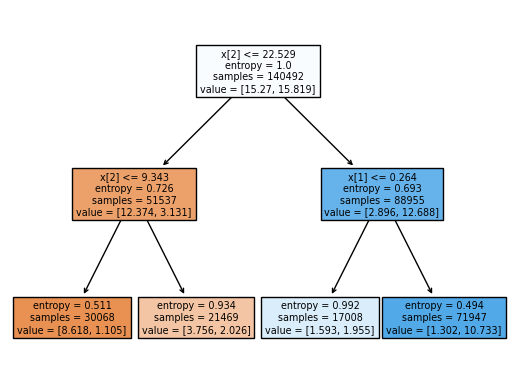

In [106]:
_ = tree.plot_tree(clf, 
                   filled=True)

In [101]:
clf = DecisionTreeClassifier(
        **best_params, random_state=10, class_weight="balanced"
    )
clf.fit(
        X_train, y_train, sample_weight=weights
    )

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, random_state=10)